In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [51]:
class BetaVAE(nn.Module):
    """β-VAE for MNIST with adjustable beta parameter"""
    
    def __init__(self, latent_dim=20, beta=4.0, input_dim=784):
        super(BetaVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.beta = beta
        self.input_dim = input_dim
        
        # ========== ENCODER ==========
        # MNIST: 1x28x28 → 28x28
        
        self.encoder = nn.Sequential(
            # 28x28 → 14x14
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (28 + 2 - 3) / 2 + 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 14x14 → 7x7
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (14 + 2 - 3) / 2 + 1
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 7x7 → 3x3                                      
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (7 + 2 - 3) / 2 + 1
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        # Calculate flattened size: 128 * 3 * 3 = 1152
        self.encoder_fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # ========== DECODER ==========
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128 * 3 * 3),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(          # (HIN - 1) * STRIDE - 2 * P + K + OP + 1
            # 3x3 → 7x7                          # (3 - 1) x 2 - 2 + (4 - 1) + 1 + 1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # # 7x7 → 14x14                        # (7 - 1) x 2 - 2 + 3 - 1 + 1 + 1
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # # 14x14 → 28x28                       # (14 - 1) x 2 - 2 + 3  - 1 + 1 + 1
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # MNIST pixels in [0, 1]
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def encode(self, x):
        """Encode input x to latent parameters"""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        h = self.encoder_fc(h)
        
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent z to reconstruction"""
        h = self.decoder_fc(z)
        h = h.view(-1, 128, 3, 3)  # Reshape to 3x3 feature map
        return self.decoder(h)
    
    def forward(self, x):
        """Full forward pass"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar, z
    
    def loss_function(self, recon_x, x, mu, logvar):
        """β-VAE loss function"""
        # Reconstruction loss (Binary Cross Entropy for MNIST)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        
        # KL Divergence
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        # β-VAE total loss
        total_loss = recon_loss + self.beta * kl_loss
        
        return {
            'loss': total_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss,
            'beta_kl_loss': self.beta * kl_loss
        }
    
    def generate(self, num_samples=16, z=None):
        """Generate samples from random z"""
        with torch.no_grad():
            if z is None:
                z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decode(z)
        return samples
    
    def reconstruct(self, x):
        """Reconstruct input x"""
        with torch.no_grad():
            recon_x, _, _, _ = self.forward(x)
        return recon_x

In [56]:
class BetaVAETrainer:
    """Trainer class for β-VAE"""
    
    def __init__(self, model, train_loader, test_loader, 
                 learning_rate=1e-3, beta_schedule=None):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # β schedule: None for constant, or list of (epoch, beta) pairs
        self.beta_schedule = beta_schedule
        self.current_beta = model.beta
        
        # Training history
        self.history = {
            'train_loss': [], 'train_recon': [], 'train_kl': [],
            'test_loss': [], 'test_recon': [], 'test_kl': []
        }
    
    def update_beta(self, epoch):
        """Update β according to schedule"""
        if self.beta_schedule is None:
            return self.model.beta
        
        for schedule_epoch, new_beta in self.beta_schedule:
            if epoch >= schedule_epoch:
                self.current_beta = new_beta
        
        self.model.beta = self.current_beta
        return self.current_beta
    
    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_recon = 0
        total_kl = 0
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch}')
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar, _ = self.model(data)
            
            # Calculate loss
            loss_dict = self.model.loss_function(recon_batch, data, mu, logvar)
            loss = loss_dict['loss']
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Accumulate statistics
            total_loss += loss.item()
            total_recon += loss_dict['recon_loss'].item()
            total_kl += loss_dict['kl_loss'].item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': loss.item() / len(data),
                'β': self.model.beta,
                'recon': loss_dict['recon_loss'].item() / len(data),
                'kl': loss_dict['kl_loss'].item() / len(data)
            })
        
        # Calculate averages
        avg_loss = total_loss / len(self.train_loader.dataset)
        avg_recon = total_recon / len(self.train_loader.dataset)
        avg_kl = total_kl / len(self.train_loader.dataset)
        
        return avg_loss, avg_recon, avg_kl
    
    def test_epoch(self):
        """Test for one epoch"""
        self.model.eval()
        total_loss = 0
        total_recon = 0
        total_kl = 0
        
        with torch.no_grad():
            for data, _ in self.test_loader:
                data = data.to(device)
                
                # Forward pass
                recon_batch, mu, logvar, _ = self.model(data)
                
                # Calculate loss
                loss_dict = self.model.loss_function(recon_batch, data, mu, logvar)
                
                total_loss += loss_dict['loss'].item()
                total_recon += loss_dict['recon_loss'].item()
                total_kl += loss_dict['kl_loss'].item()
        
        # Calculate averages
        avg_loss = total_loss / len(self.test_loader.dataset)
        avg_recon = total_recon / len(self.test_loader.dataset)
        avg_kl = total_kl / len(self.test_loader.dataset)
        
        return avg_loss, avg_recon, avg_kl
    
    def train(self, num_epochs=50, save_dir='checkpoints'):
        """Full training loop"""
        os.makedirs(save_dir, exist_ok=True)
        
        print(f"Starting training with β={self.model.beta}")
        print(f"Latent dimension: {self.model.latent_dim}")
        print(f"Training on {len(self.train_loader.dataset)} samples")
        
        for epoch in range(1, num_epochs + 1):
            # Update β if using schedule
            beta = self.update_beta(epoch)
            
            # Train
            train_loss, train_recon, train_kl = self.train_epoch(epoch)
            
            # Test
            test_loss, test_recon, test_kl = self.test_epoch()
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_recon'].append(train_recon)
            self.history['train_kl'].append(train_kl)
            self.history['test_loss'].append(test_loss)
            self.history['test_recon'].append(test_recon)
            self.history['test_kl'].append(test_kl)
            
            # Print epoch summary
            print(f"\nEpoch {epoch}/{num_epochs}:")
            print(f"  β = {beta:.3f}")
            print(f"  Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})")
            print(f"  Test Loss:  {test_loss:.4f} (Recon: {test_recon:.4f}, KL: {test_kl:.4f})")
            
            # Save model checkpoint
            if epoch % 10 == 0:
                checkpoint_path = os.path.join(save_dir, f'betavae_epoch_{epoch}.pth')
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'beta': beta,
                    'history': self.history,
                }, checkpoint_path)
                print(f"  Checkpoint saved: {checkpoint_path}")
            
            # # Visualize every 5 epochs
            # if epoch % 5 == 0:
            #     self.visualize_results(epoch, save_dir)
        
        # Save final model
        final_path = os.path.join(save_dir, 'betavae_final.pth')
        torch.save(self.model.state_dict(), final_path)
        print(f"\nFinal model saved: {final_path}")
        
        return self.history

In [57]:
class BetaVAEVisualizer:
    """Visualization tools for β-VAE"""
    
    def __init__(self, model):
        self.model = model
        self.model.eval()
    
    def plot_reconstructions(self, data_loader, num_samples=8, save_path=None):
        """Plot original vs reconstructed images"""
        self.model.eval()
        
        # Get batch of data
        data_iter = iter(data_loader)
        images, labels = next(data_iter)
        images = images[:num_samples].to(device)
        
        # Reconstruct
        with torch.no_grad():
            reconstructions, _, _, _ = self.model(images)
        
        # Move to CPU for plotting
        images = images.cpu()
        reconstructions = reconstructions.cpu()
        
        # Plot
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
        
        for i in range(num_samples):
            # Original
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title(f'Original {labels[i].item()}')
            
            # Reconstruction
            axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Reconstructed')
        
        plt.suptitle(f'β-VAE Reconstructions (β={self.model.beta})')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def plot_generated_samples(self, num_samples=25, save_path=None):
        """Plot generated samples from random z"""
        self.model.eval()
        
        with torch.no_grad():
            samples = self.model.generate(num_samples)
        
        samples = samples.cpu()
        
        # Arrange in grid
        grid_size = int(np.sqrt(num_samples))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        
        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                axes[i, j].imshow(samples[idx].squeeze(), cmap='gray')
                axes[i, j].axis('off')
        
        plt.suptitle(f'Generated Samples from Random z (β={self.model.beta})')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def plot_latent_space(self, data_loader, num_samples=1000, save_path=None):
        """Visualize latent space (first 2 dimensions)"""
        self.model.eval()
        
        all_mus = []
        all_labels = []
        
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(data_loader):
                if len(all_mus) >= num_samples:
                    break
                
                data = data.to(device)
                mu, _ = self.model.encode(data)
                
                all_mus.append(mu.cpu())
                all_labels.append(labels)
        
        mus = torch.cat(all_mus)[:num_samples]
        labels = torch.cat(all_labels)[:num_samples]
        
        # Plot 2D latent space
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(mus[:, 0], mus[:, 1], c=labels, 
                             cmap='tab10', alpha=0.6, s=20)
        plt.colorbar(scatter, label='Digit Class')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.title(f'Latent Space Visualization (β={self.model.beta})')
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def plot_latent_traversal(self, fixed_z=None, dim_idx=0, num_steps=11, save_path=None):
        """Traverse one latent dimension while keeping others fixed"""
        self.model.eval()
        
        if fixed_z is None:
            fixed_z = torch.zeros(1, self.model.latent_dim).to(device)
        
        # Create traversal range (-3 to 3 sigma)
        traversal_range = torch.linspace(-3, 3, num_steps).to(device)
        
        images = []
        with torch.no_grad():
            for val in traversal_range:
                z = fixed_z.clone()
                z[0, dim_idx] = val
                recon = self.model.decode(z)
                images.append(recon.cpu())
        
        # Plot traversal
        fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))
        
        for i in range(num_steps):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'z[{dim_idx}]={traversal_range[i]:.1f}')
        
        plt.suptitle(f'Latent Dimension {dim_idx} Traversal (β={self.model.beta})')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def plot_training_history(self, history, save_path=None):
        """Plot training and test losses"""
        epochs = range(1, len(history['train_loss']) + 1)
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        # Total loss
        axes[0, 0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
        axes[0, 0].plot(epochs, history['test_loss'], label='Test', linewidth=2)
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Total Loss')
        axes[0, 0].set_title('Total Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Reconstruction loss
        axes[0, 1].plot(epochs, history['train_recon'], label='Train', linewidth=2)
        axes[0, 1].plot(epochs, history['test_recon'], label='Test', linewidth=2)
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Reconstruction Loss')
        axes[0, 1].set_title('Reconstruction Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # KL loss
        axes[1, 0].plot(epochs, history['train_kl'], label='Train', linewidth=2)
        axes[1, 0].plot(epochs, history['test_kl'], label='Test', linewidth=2)
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('KL Loss')
        axes[1, 0].set_title('KL Divergence Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Ratio (KL/Recon)
        train_ratio = np.array(history['train_kl']) / np.array(history['train_recon'])
        test_ratio = np.array(history['test_kl']) / np.array(history['test_recon'])
        axes[1, 1].plot(epochs, train_ratio, label='Train', linewidth=2)
        axes[1, 1].plot(epochs, test_ratio, label='Test', linewidth=2)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('KL / Recon Ratio')
        axes[1, 1].set_title('KL to Reconstruction Ratio')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f'Training History (β={self.model.beta})')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()

Loading MNIST dataset...
Train samples: 60000
Test samples: 10000

Creating β-VAE model...
Model architecture:
  Latent dimension: 10
  β parameter: 4.0
  Total parameters: 1,071,765

Starting training...
Starting training with β=4.0
Latent dimension: 10
Training on 60000 samples


Epoch 1: 100%|██████████| 469/469 [00:05<00:00, 90.60it/s, loss=1.74e+3, β=4, recon=179, kl=391]    



Epoch 1/50:
  β = 4.000
  Train Loss: 2453285162362.6094 (Recon: 216.4388, KL: 613321290536.8589)
  Test Loss:  2873.7645 (Recon: 184.9548, KL: 672.2024)


Epoch 2: 100%|██████████| 469/469 [00:05<00:00, 89.86it/s, loss=1.49e+3, β=4, recon=190, kl=326]    



Epoch 2/50:
  β = 4.000
  Train Loss: 1789.9512 (Recon: 187.5160, KL: 400.6088)
  Test Loss:  2231.4666 (Recon: 189.7127, KL: 510.4385)


Epoch 3: 100%|██████████| 469/469 [00:05<00:00, 89.25it/s, loss=1.34e+3, β=4, recon=189, kl=288]    



Epoch 3/50:
  β = 4.000
  Train Loss: 1459.3084 (Recon: 190.6766, KL: 317.1580)
  Test Loss:  1870.7835 (Recon: 191.6488, KL: 419.7837)


Epoch 4: 100%|██████████| 469/469 [00:05<00:00, 92.31it/s, loss=1.17e+3, β=4, recon=191, kl=244]    



Epoch 4/50:
  β = 4.000
  Train Loss: 1286.4684 (Recon: 191.2976, KL: 273.7927)
  Test Loss:  1662.4356 (Recon: 194.5703, KL: 366.9663)


Epoch 5: 100%|██████████| 469/469 [00:05<00:00, 90.04it/s, loss=1.1e+3, β=4, recon=188, kl=228]     



Epoch 5/50:
  β = 4.000
  Train Loss: 1176.1704 (Recon: 187.8593, KL: 247.0778)
  Test Loss:  1471.7429 (Recon: 188.5608, KL: 320.7955)


Epoch 6: 100%|██████████| 469/469 [00:05<00:00, 92.23it/s, loss=1.02e+3, β=4, recon=175, kl=212]    



Epoch 6/50:
  β = 4.000
  Train Loss: 1090.1235 (Recon: 179.1564, KL: 227.7418)
  Test Loss:  1294.1632 (Recon: 181.7609, KL: 278.1006)


Epoch 7: 100%|██████████| 469/469 [00:05<00:00, 91.19it/s, loss=957, β=4, recon=159, kl=200]    



Epoch 7/50:
  β = 4.000
  Train Loss: 996.0587 (Recon: 167.3676, KL: 207.1728)
  Test Loss:  1267.5052 (Recon: 161.5682, KL: 276.4842)


Epoch 8: 100%|██████████| 469/469 [00:05<00:00, 89.79it/s, loss=1.04e+3, β=4, recon=153, kl=221]



Epoch 8/50:
  β = 4.000
  Train Loss: 942.4146 (Recon: 155.4634, KL: 196.7378)
  Test Loss:  1151.7017 (Recon: 160.1244, KL: 247.8943)


Epoch 9: 100%|██████████| 469/469 [00:05<00:00, 91.74it/s, loss=866, β=4, recon=141, kl=181]    



Epoch 9/50:
  β = 4.000
  Train Loss: 889.7432 (Recon: 146.4834, KL: 185.8150)
  Test Loss:  1060.5093 (Recon: 147.2747, KL: 228.3086)


Epoch 10: 100%|██████████| 469/469 [00:05<00:00, 91.35it/s, loss=795, β=4, recon=134, kl=165]    



Epoch 10/50:
  β = 4.000
  Train Loss: 838.0980 (Recon: 141.0047, KL: 174.2733)
  Test Loss:  993.9663 (Recon: 142.5646, KL: 212.8504)
  Checkpoint saved: betavae_checkpoints/betavae_epoch_10.pth


Epoch 11: 100%|██████████| 469/469 [00:05<00:00, 91.78it/s, loss=766, β=4, recon=133, kl=158]    



Epoch 11/50:
  β = 4.000
  Train Loss: 800.9334 (Recon: 137.2919, KL: 165.9104)
  Test Loss:  940.9502 (Recon: 138.7071, KL: 200.5608)


Epoch 12: 100%|██████████| 469/469 [00:05<00:00, 91.39it/s, loss=741, β=4, recon=134, kl=152]    



Epoch 12/50:
  β = 4.000
  Train Loss: 764.5587 (Recon: 134.3191, KL: 157.5599)
  Test Loss:  851.2108 (Recon: 136.3926, KL: 178.7046)


Epoch 13: 100%|██████████| 469/469 [00:05<00:00, 91.91it/s, loss=694, β=4, recon=130, kl=141]    



Epoch 13/50:
  β = 4.000
  Train Loss: 724.4641 (Recon: 131.4558, KL: 148.2521)
  Test Loss:  817.8391 (Recon: 150.6395, KL: 166.7999)


Epoch 14: 100%|██████████| 469/469 [00:05<00:00, 91.61it/s, loss=662, β=4, recon=131, kl=133]    



Epoch 14/50:
  β = 4.000
  Train Loss: 691.6448 (Recon: 128.5001, KL: 140.7862)
  Test Loss:  763.4075 (Recon: 139.3379, KL: 156.0174)


Epoch 15: 100%|██████████| 469/469 [00:05<00:00, 91.37it/s, loss=625, β=4, recon=126, kl=125]     



Epoch 15/50:
  β = 4.000
  Train Loss: 651.9219 (Recon: 126.4757, KL: 131.3615)
  Test Loss:  720.2619 (Recon: 128.8166, KL: 147.8613)


Epoch 16: 100%|██████████| 469/469 [00:05<00:00, 91.98it/s, loss=633, β=4, recon=132, kl=125]    



Epoch 16/50:
  β = 4.000
  Train Loss: 634.7725 (Recon: 124.6927, KL: 127.5199)
  Test Loss:  717.8357 (Recon: 127.3058, KL: 147.6325)


Epoch 17: 100%|██████████| 469/469 [00:05<00:00, 91.88it/s, loss=590, β=4, recon=118, kl=118]    



Epoch 17/50:
  β = 4.000
  Train Loss: 616.4907 (Recon: 122.8641, KL: 123.4067)
  Test Loss:  692.0578 (Recon: 125.3481, KL: 141.6774)


Epoch 18: 100%|██████████| 469/469 [00:05<00:00, 92.14it/s, loss=601, β=4, recon=123, kl=119]    



Epoch 18/50:
  β = 4.000
  Train Loss: 610.2279 (Recon: 121.1516, KL: 122.2691)
  Test Loss:  660.0068 (Recon: 121.2407, KL: 134.6915)


Epoch 19: 100%|██████████| 469/469 [00:05<00:00, 92.36it/s, loss=3.3e+3, β=4, recon=140, kl=790]     



Epoch 19/50:
  β = 4.000
  Train Loss: 614.3497 (Recon: 120.4259, KL: 123.4809)
  Test Loss:  1496.4105 (Recon: 377.6854, KL: 279.6813)


Epoch 20: 100%|██████████| 469/469 [00:05<00:00, 91.21it/s, loss=573, β=4, recon=124, kl=112]



Epoch 20/50:
  β = 4.000
  Train Loss: 615.4813 (Recon: 118.4572, KL: 124.2560)
  Test Loss:  629.6599 (Recon: 123.3694, KL: 126.5726)
  Checkpoint saved: betavae_checkpoints/betavae_epoch_20.pth


Epoch 21: 100%|██████████| 469/469 [00:05<00:00, 91.57it/s, loss=687, β=4, recon=119, kl=142]        



Epoch 21/50:
  β = 4.000
  Train Loss: 679.3518 (Recon: 118.4041, KL: 140.2369)
  Test Loss:  838.0712 (Recon: 118.5779, KL: 179.8733)


Epoch 22: 100%|██████████| 469/469 [00:05<00:00, 88.04it/s, loss=592, β=4, recon=117, kl=119]    



Epoch 22/50:
  β = 4.000
  Train Loss: 628.4079 (Recon: 116.5729, KL: 127.9587)
  Test Loss:  708.0013 (Recon: 117.5315, KL: 147.6174)


Epoch 23: 100%|██████████| 469/469 [00:05<00:00, 91.73it/s, loss=561, β=4, recon=116, kl=111]



Epoch 23/50:
  β = 4.000
  Train Loss: 571.0774 (Recon: 115.8447, KL: 113.8082)
  Test Loss:  704.9436 (Recon: 117.3726, KL: 146.8927)


Epoch 24: 100%|██████████| 469/469 [00:05<00:00, 91.83it/s, loss=542, β=4, recon=122, kl=105]    



Epoch 24/50:
  β = 4.000
  Train Loss: 549.0324 (Recon: 115.5833, KL: 108.3623)
  Test Loss:  656.9692 (Recon: 120.0070, KL: 134.2406)


Epoch 25: 100%|██████████| 469/469 [00:05<00:00, 91.42it/s, loss=784, β=4, recon=114, kl=167]        



Epoch 25/50:
  β = 4.000
  Train Loss: 3859.8161 (Recon: 116.6901, KL: 935.7815)
  Test Loss:  881.0531 (Recon: 142.4651, KL: 184.6470)


Epoch 26: 100%|██████████| 469/469 [00:05<00:00, 92.79it/s, loss=723, β=4, recon=113, kl=152]    



Epoch 26/50:
  β = 4.000
  Train Loss: 748.8867 (Recon: 112.8431, KL: 159.0109)
  Test Loss:  755.4655 (Recon: 112.6507, KL: 160.7037)


Epoch 27: 100%|██████████| 469/469 [00:05<00:00, 90.57it/s, loss=675, β=4, recon=115, kl=140]    



Epoch 27/50:
  β = 4.000
  Train Loss: 706.4978 (Recon: 112.1513, KL: 148.5866)
  Test Loss:  1228.8713 (Recon: 112.5488, KL: 279.0806)


Epoch 28: 100%|██████████| 469/469 [00:05<00:00, 92.37it/s, loss=697, β=4, recon=123, kl=144]    



Epoch 28/50:
  β = 4.000
  Train Loss: 673.7819 (Recon: 112.4695, KL: 140.3281)
  Test Loss:  715.4779 (Recon: 117.6485, KL: 149.4574)


Epoch 29: 100%|██████████| 469/469 [00:05<00:00, 91.77it/s, loss=684, β=4, recon=116, kl=142]        



Epoch 29/50:
  β = 4.000
  Train Loss: 741.7571 (Recon: 112.2647, KL: 157.3731)
  Test Loss:  735.7715 (Recon: 125.2891, KL: 152.6206)


Epoch 30: 100%|██████████| 469/469 [00:05<00:00, 90.92it/s, loss=674, β=4, recon=110, kl=141]        



Epoch 30/50:
  β = 4.000
  Train Loss: 681.2178 (Recon: 111.5076, KL: 142.4276)
  Test Loss:  730.4344 (Recon: 119.6479, KL: 152.6966)
  Checkpoint saved: betavae_checkpoints/betavae_epoch_30.pth


Epoch 31: 100%|██████████| 469/469 [00:05<00:00, 91.97it/s, loss=657, β=4, recon=109, kl=137]    



Epoch 31/50:
  β = 4.000
  Train Loss: 661.2367 (Recon: 111.6140, KL: 137.4057)
  Test Loss:  737.3444 (Recon: 111.5651, KL: 156.4448)


Epoch 32: 100%|██████████| 469/469 [00:05<00:00, 91.94it/s, loss=592, β=4, recon=108, kl=121]    



Epoch 32/50:
  β = 4.000
  Train Loss: 622.1243 (Recon: 111.3762, KL: 127.6870)
  Test Loss:  143785727.7047 (Recon: 115.5062, KL: 35946403.6687)


Epoch 33: 100%|██████████| 469/469 [00:05<00:00, 92.84it/s, loss=578, β=4, recon=111, kl=117]   



Epoch 33/50:
  β = 4.000
  Train Loss: 609.7927 (Recon: 111.7289, KL: 124.5160)
  Test Loss:  283198674.9200 (Recon: 115.5885, KL: 70799640.4680)


Epoch 34: 100%|██████████| 469/469 [00:05<00:00, 91.35it/s, loss=627, β=4, recon=102, kl=131]        



Epoch 34/50:
  β = 4.000
  Train Loss: 665.7480 (Recon: 111.4931, KL: 138.5637)
  Test Loss:  1318.1580 (Recon: 113.6106, KL: 301.1369)


Epoch 35: 100%|██████████| 469/469 [00:05<00:00, 89.94it/s, loss=655, β=4, recon=111, kl=136]



Epoch 35/50:
  β = 4.000
  Train Loss: 626.8784 (Recon: 111.8524, KL: 128.7565)
  Test Loss:  435574.7619 (Recon: 119.7374, KL: 108863.7560)


Epoch 36: 100%|██████████| 469/469 [00:05<00:00, 92.40it/s, loss=1.18e+3, β=4, recon=114, kl=267]



Epoch 36/50:
  β = 4.000
  Train Loss: 600.1179 (Recon: 112.2690, KL: 121.9622)
  Test Loss:  23564.8408 (Recon: 128.1897, KL: 5859.1627)


Epoch 37: 100%|██████████| 469/469 [00:05<00:00, 91.70it/s, loss=557, β=4, recon=114, kl=111]



Epoch 37/50:
  β = 4.000
  Train Loss: 569.1515 (Recon: 112.1528, KL: 114.2497)
  Test Loss:  2875015.6623 (Recon: 114.9572, KL: 718725.1804)


Epoch 38: 100%|██████████| 469/469 [00:05<00:00, 92.46it/s, loss=730, β=4, recon=112, kl=154]        



Epoch 38/50:
  β = 4.000
  Train Loss: 667.0752 (Recon: 113.0093, KL: 138.5165)
  Test Loss:  296831.5892 (Recon: 116.8354, KL: 74178.6886)


Epoch 39: 100%|██████████| 469/469 [00:05<00:00, 91.12it/s, loss=634, β=4, recon=109, kl=131]    



Epoch 39/50:
  β = 4.000
  Train Loss: 665.8941 (Recon: 112.3604, KL: 138.3834)
  Test Loss:  787876.6973 (Recon: 120.7007, KL: 196939.0052)


Epoch 40: 100%|██████████| 469/469 [00:05<00:00, 90.98it/s, loss=610, β=4, recon=111, kl=125]



Epoch 40/50:
  β = 4.000
  Train Loss: 623.5028 (Recon: 113.2193, KL: 127.5709)
  Test Loss:  377322.0812 (Recon: 115.7663, KL: 94301.5770)
  Checkpoint saved: betavae_checkpoints/betavae_epoch_40.pth


Epoch 41: 100%|██████████| 469/469 [00:05<00:00, 93.02it/s, loss=546, β=4, recon=113, kl=108]    



Epoch 41/50:
  β = 4.000
  Train Loss: 587.6449 (Recon: 113.5514, KL: 118.5234)
  Test Loss:  436863.6350 (Recon: 122.0688, KL: 109185.3856)


Epoch 42: 100%|██████████| 469/469 [00:05<00:00, 90.08it/s, loss=2.01e+3, β=4, recon=111, kl=474]    



Epoch 42/50:
  β = 4.000
  Train Loss: 552956.5989 (Recon: 125.0779, KL: 138207.8828)
  Test Loss:  2057.3698 (Recon: 119.9361, KL: 484.3584)


Epoch 43: 100%|██████████| 469/469 [00:05<00:00, 90.85it/s, loss=1.96e+3, β=4, recon=106, kl=464]   



Epoch 43/50:
  β = 4.000
  Train Loss: 2024.4345 (Recon: 113.7682, KL: 477.6666)
  Test Loss:  2029.5393 (Recon: 114.7824, KL: 478.6892)


Epoch 44: 100%|██████████| 469/469 [00:05<00:00, 90.70it/s, loss=2.01e+3, β=4, recon=109, kl=476]   



Epoch 44/50:
  β = 4.000
  Train Loss: 2031.6849 (Recon: 112.3206, KL: 479.8411)
  Test Loss:  80120.9044 (Recon: 125.6317, KL: 19998.8183)


Epoch 45: 100%|██████████| 469/469 [00:05<00:00, 91.15it/s, loss=1.99e+3, β=4, recon=113, kl=470] 



Epoch 45/50:
  β = 4.000
  Train Loss: 1977.3065 (Recon: 111.3187, KL: 466.4969)
  Test Loss:  2066.4050 (Recon: 119.1477, KL: 486.8143)


Epoch 46: 100%|██████████| 469/469 [00:05<00:00, 92.62it/s, loss=1.95e+3, β=4, recon=112, kl=461]    



Epoch 46/50:
  β = 4.000
  Train Loss: 1964.7562 (Recon: 111.6786, KL: 463.2694)
  Test Loss:  2350.2656 (Recon: 113.1549, KL: 559.2777)


Epoch 47: 100%|██████████| 469/469 [00:05<00:00, 91.43it/s, loss=2.21e+3, β=4, recon=113, kl=523]    



Epoch 47/50:
  β = 4.000
  Train Loss: 2129.1558 (Recon: 111.9998, KL: 504.2890)
  Test Loss:  2804.1259 (Recon: 409.5298, KL: 598.6490)


Epoch 48: 100%|██████████| 469/469 [00:05<00:00, 92.90it/s, loss=2.16e+3, β=4, recon=111, kl=514] 



Epoch 48/50:
  β = 4.000
  Train Loss: 2207.1871 (Recon: 110.4788, KL: 524.1771)
  Test Loss:  2220.6933 (Recon: 112.2217, KL: 527.1179)


Epoch 49: 100%|██████████| 469/469 [00:05<00:00, 90.39it/s, loss=2.06e+3, β=4, recon=108, kl=489] 



Epoch 49/50:
  β = 4.000
  Train Loss: 2116.9297 (Recon: 110.6116, KL: 501.5795)
  Test Loss:  2726.4242 (Recon: 135.0939, KL: 647.8326)


Epoch 50: 100%|██████████| 469/469 [00:05<00:00, 92.40it/s, loss=2.79e+3, β=4, recon=126, kl=665]    



Epoch 50/50:
  β = 4.000
  Train Loss: 3840.0041 (Recon: 111.6893, KL: 932.0787)
  Test Loss:  2981.5421 (Recon: 294.6317, KL: 671.7276)
  Checkpoint saved: betavae_checkpoints/betavae_epoch_50.pth

Final model saved: betavae_checkpoints/betavae_final.pth

Generating visualizations...


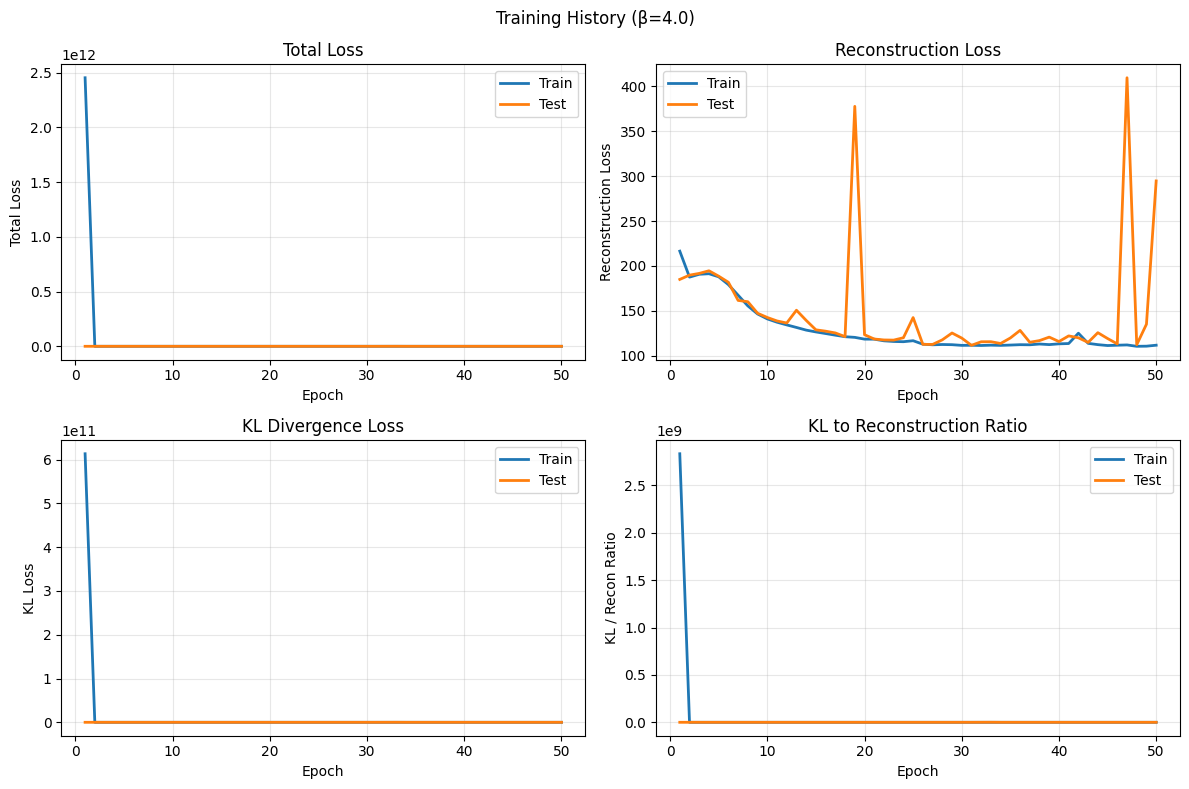

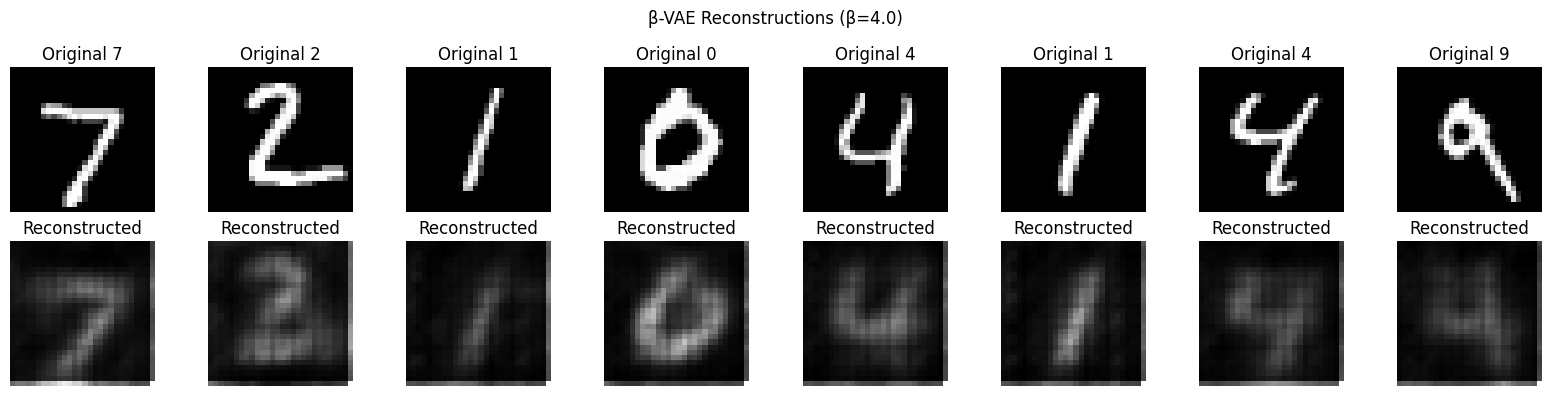

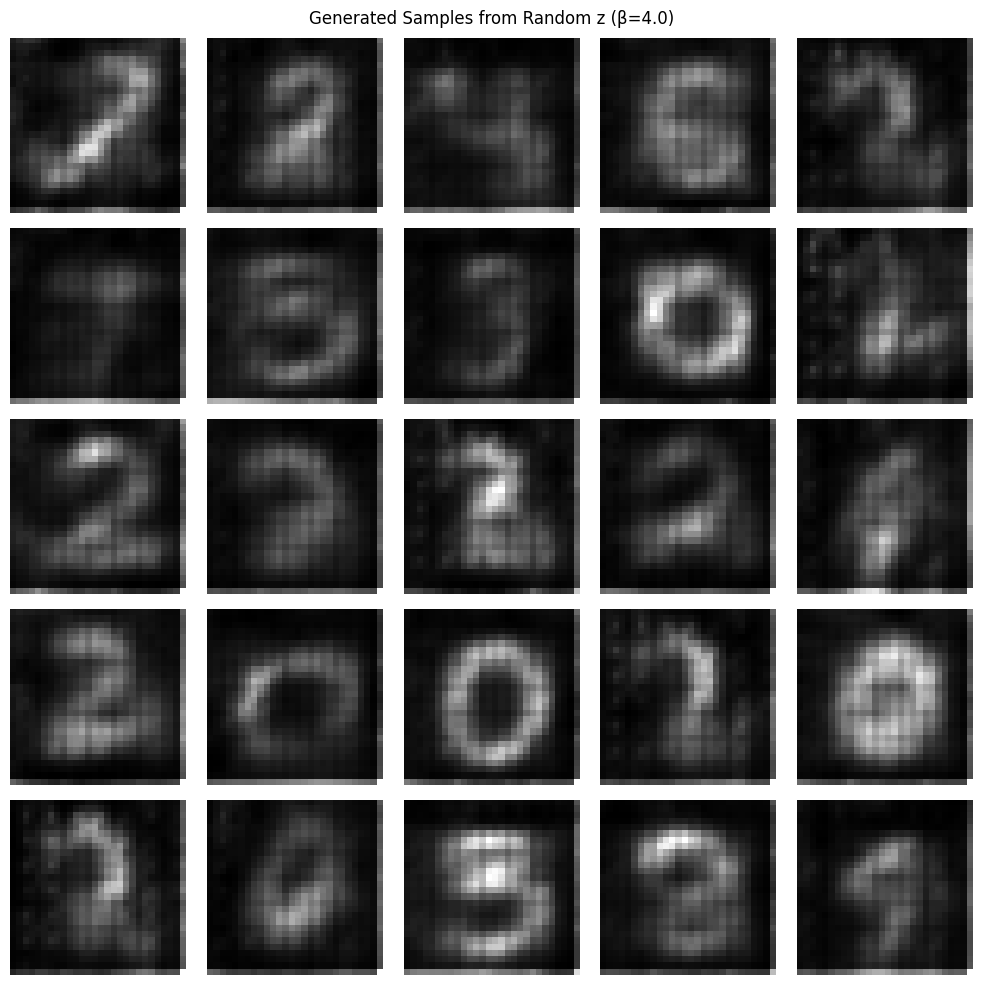

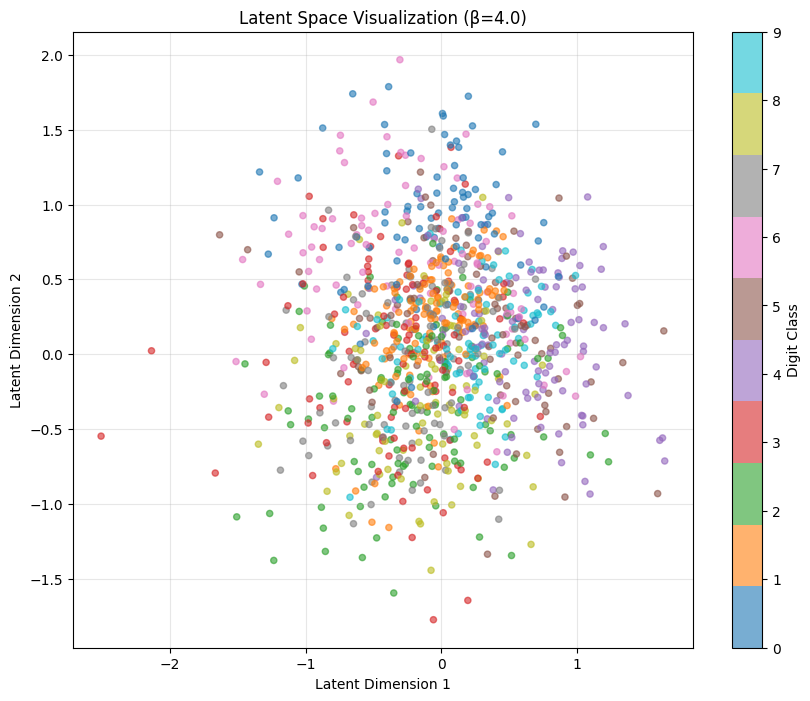

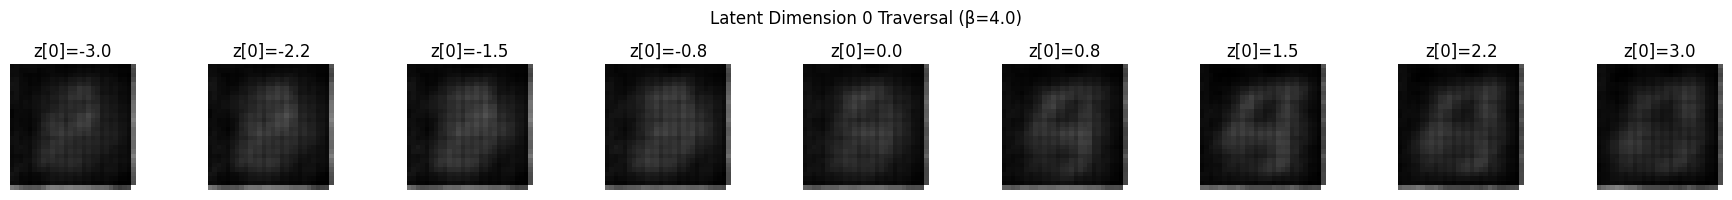

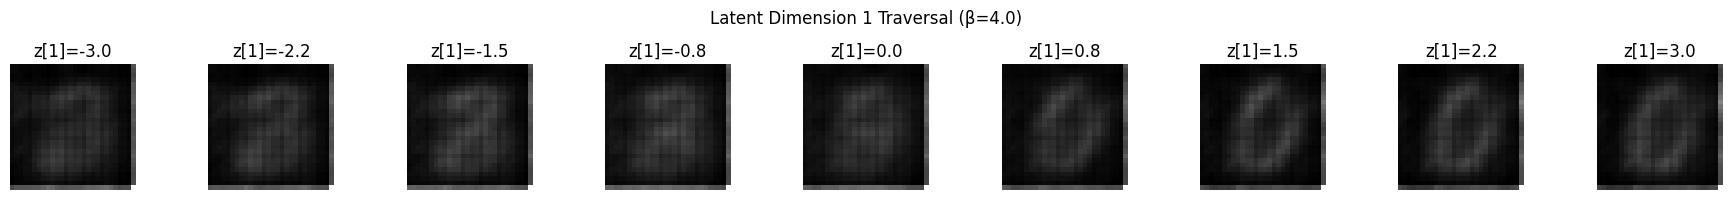

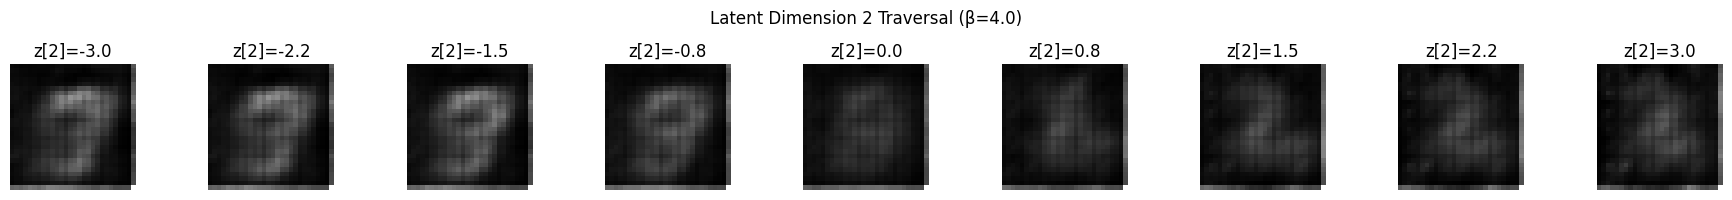

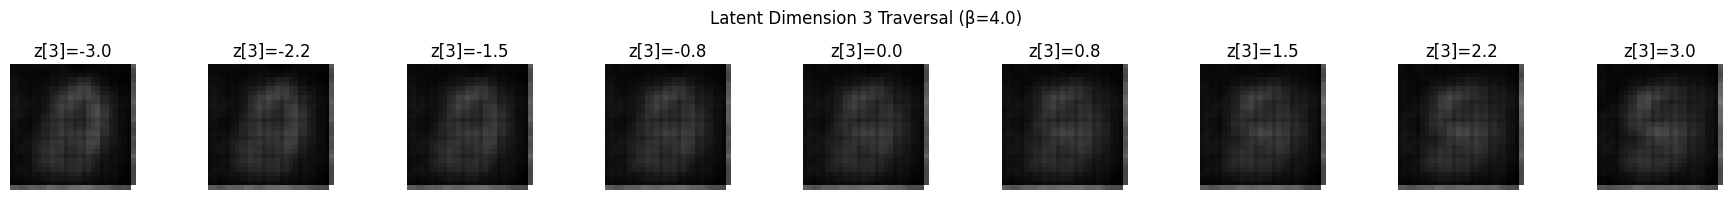

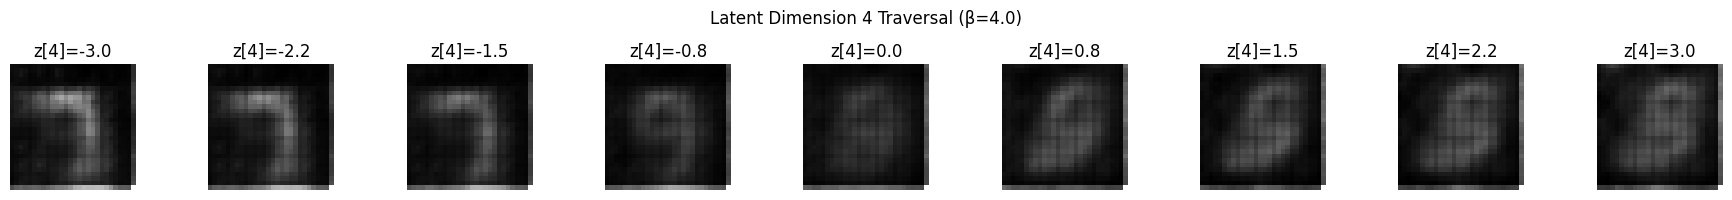


Training complete!
All visualizations saved to current directory.


In [58]:

"""Main training script"""
# ========== HYPERPARAMETERS ==========
LATENT_DIM = 10        # Latent space dimension
BETA = 4.0             # β value (higher = more disentangled)
BATCH_SIZE = 128
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3

# Optional: β schedule for annealing
# Format: [(epoch, beta), ...]
BETA_SCHEDULE = None  # Constant β
# BETA_SCHEDULE = [(0, 0.0), (10, 1.0), (20, 4.0)]  # Annealing

# ========== DATA LOADING ==========
print("Loading MNIST dataset...")

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Train dataset
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

# Test dataset
test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=2
)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# ========== CREATE MODEL ==========
print(f"\nCreating β-VAE model...")
model = BetaVAE(
    latent_dim=LATENT_DIM,
    beta=BETA,
    input_dim=784
)

print(f"Model architecture:")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  β parameter: {BETA}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# ========== TRAINING ==========
print(f"\nStarting training...")

trainer = BetaVAETrainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    learning_rate=LEARNING_RATE,
    beta_schedule=BETA_SCHEDULE
)

history = trainer.train(
    num_epochs=NUM_EPOCHS,
    save_dir='betavae_checkpoints'
)

# ========== VISUALIZATION ==========
print(f"\nGenerating visualizations...")

visualizer = BetaVAEVisualizer(model)

# 1. Plot training history
visualizer.plot_training_history(
    history, 
    save_path='betavae_training_history.png'
)

# 2. Plot reconstructions
visualizer.plot_reconstructions(
    test_loader, 
    num_samples=8,
    save_path='betavae_reconstructions.png'
)

# 3. Plot generated samples
visualizer.plot_generated_samples(
    num_samples=25,
    save_path='betavae_generated_samples.png'
)

# 4. Plot latent space (first 2 dimensions)
visualizer.plot_latent_space(
    test_loader, 
    num_samples=1000,
    save_path='betavae_latent_space.png'
)

# 5. Plot latent traversals for first few dimensions
for dim in range(min(5, LATENT_DIM)):
    visualizer.plot_latent_traversal(
        dim_idx=dim,
        num_steps=9,
        save_path=f'betavae_latent_traversal_dim{dim}.png'
    )

print("\nTraining complete!")
print("All visualizations saved to current directory.")

return model, history

In [60]:
def analyze_model(model_path, test_loader):
    """Load and analyze a trained β-VAE model"""
    
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model with same architecture
    model = BetaVAE(latent_dim=10, beta=4.0)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Loaded model from {model_path}")
    print(f"β: {model.beta}")
    
    # Create visualizer
    visualizer = BetaVAEVisualizer(model)
    
    # 1. Quantitative evaluation
    print("\n=== Quantitative Evaluation ===")
    
    total_recon_loss = 0
    total_kl_loss = 0
    num_samples = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar, _ = model(data)
            
            # Calculate losses
            loss_dict = model.loss_function(recon, data, mu, logvar)
            
            total_recon_loss += loss_dict['recon_loss'].item()
            total_kl_loss += loss_dict['kl_loss'].item()
            num_samples += len(data)
    
    avg_recon = total_recon_loss / num_samples
    avg_kl = total_kl_loss / num_samples
    
    print(f"Average Reconstruction Loss: {avg_recon:.4f}")
    print(f"Average KL Loss: {avg_kl:.4f}")
    print(f"KL/Recon Ratio: {avg_kl/avg_recon:.4f}")
    
    # 2. Disentanglement metrics (simplified)
    print("\n=== Disentanglement Analysis ===")
    
    # Get latent representations for each class
    class_mus = [[] for _ in range(10)]
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            
            mu = mu.cpu()
            for i in range(len(labels)):
                class_mus[labels[i].item()].append(mu[i])
    
    # Calculate class means and variances
    class_means = []
    class_vars = []
    
    for i in range(10):
        if len(class_mus[i]) > 0:
            mus = torch.stack(class_mus[i])
            class_means.append(mus.mean(dim=0))
            class_vars.append(mus.var(dim=0))
    
    if len(class_means) > 0:
        class_means = torch.stack(class_means)
        class_vars = torch.stack(class_vars)
        
        print(f"Mean variance across classes (per dimension):")
        for dim in range(model.latent_dim):
            dim_vars = class_vars[:, dim]
            print(f"  Dim {dim}: Mean var = {dim_vars.mean():.4f}, Std = {dim_vars.std():.4f}")
    
    # 3. Visualizations
    print("\n=== Generating Visualizations ===")
    visualizer.plot_reconstructions(test_loader, num_samples=8)
    visualizer.plot_generated_samples(num_samples=25)
    visualizer.plot_latent_space(test_loader, num_samples=1000)
    
    return model

# Example usage:
analyze_model('betavae_checkpoints/betavae_final.pth', test_loader)

NameError: name 'test_loader' is not defined